In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset, random_split, Dataset
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Utilize GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [4]:
# Transforms for training (with augmentation)
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Data augmentation
    transforms.RandomRotation((-10, 10)),
    transforms.RandomResizedCrop(128, scale=(0.2, 1)),
    transforms.Resize((128, 128)),  # Resize to 128x128
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
    transforms.ToTensor(),  # Convert to tensor (normalizes to [0, 1])
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

# Transforms for validation/test (no augmentation)
val_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [5]:
#Load full dataset
data_dir = "dataset"
dataset = ImageFolder(data_dir, transform=None)


In [6]:
class TransformingSubset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset  # typically ImageFolder
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [7]:
# Test/train split
val_pct = 0.2
val_size = int(val_pct * len(dataset))
train_size = len(dataset) - val_size

raw_train_dataset, raw_val_dataset = random_split(dataset, [train_size, val_size])

# Assign different transforms manually
train_dataset = TransformingSubset(raw_train_dataset, train_transforms)
val_dataset = TransformingSubset(raw_val_dataset, val_transforms)


Training samples: 19999, Validation samples: 4999


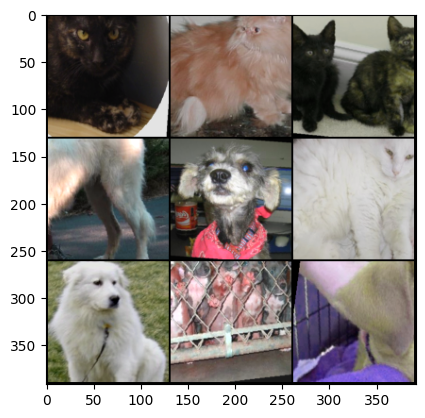

In [8]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
images, labels = next(iter(train_loader))
grid = torchvision.utils.make_grid(images[:9], nrow=3, padding=2, normalize=True)

print(f"Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")
plt.imshow(grid.permute(1,2,0))

In [9]:
class BasicCNN(nn.Module):
    def __init__(self):
        super(BasicCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1), 
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (128x128) -> (64x64)

            nn.Conv2d(16, 32, 3, padding=1),  
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # (64x64) -> (32x32)

            nn.Conv2d(32, 64, 3, padding=1), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # (32x32) -> (16x16)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(64 * 16 * 16, 128),
            nn.ReLU(),
            nn.Linear(128, 2) # binary classification
        ) 

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)


In [10]:
model = BasicCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                        factor=0.5, patience=2)

In [11]:
# Reset model weights
for layer in model.children():
   if hasattr(layer, 'reset_parameters'):
       layer.reset_parameters()

This is the training loop. With my basic CNN architecture I consistantly get around 80% accuracy.

In [12]:
num_epochs = 10
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
best_val_accuracy = 0.0

for epoch in range(num_epochs):
    # ----- Training -----
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()

    avg_train_loss = train_loss / len(train_loader.dataset)
    train_accuracy = 100. * train_correct / train_total

    # ----- Evaluation -----
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    avg_val_loss = val_loss / len(val_loader.dataset)
    val_accuracy = 100. * val_correct / val_total
    
    # Save training losses and accuracy for plotting later
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    # Save model if the accuracy is better than previous epoch
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save({'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'val_accuracy': val_accuracy
                    }, "weights.pth")
        print(
            f"[Info] saved new checkpoint with val accuracy: {val_accuracy:.2f}%")

    scheduler.step(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(
        f"  Train Loss: {avg_train_loss:.4f}, Accuracy: {train_accuracy:.2f}%")
    print(f"  Val   Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")

/home/stelios/Documents/projects/torch_venv/lib64/python3.13/site-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


[Info] saved new checkpoint with val accuracy: 62.03%
Epoch 1/10
  Train Loss: 0.6619, Accuracy: 62.66%
  Val   Loss: 0.6382, Accuracy: 62.03%


/home/stelios/Documents/projects/torch_venv/lib64/python3.13/site-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


[Info] saved new checkpoint with val accuracy: 74.47%
Epoch 2/10
  Train Loss: 0.5719, Accuracy: 69.98%
  Val   Loss: 0.5241, Accuracy: 74.47%


/home/stelios/Documents/projects/torch_venv/lib64/python3.13/site-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


[Info] saved new checkpoint with val accuracy: 76.10%
Epoch 3/10
  Train Loss: 0.5420, Accuracy: 72.24%
  Val   Loss: 0.4930, Accuracy: 76.10%


/home/stelios/Documents/projects/torch_venv/lib64/python3.13/site-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 4/10
  Train Loss: 0.5228, Accuracy: 74.06%
  Val   Loss: 0.5231, Accuracy: 72.65%


/home/stelios/Documents/projects/torch_venv/lib64/python3.13/site-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


[Info] saved new checkpoint with val accuracy: 77.14%
Epoch 5/10
  Train Loss: 0.5061, Accuracy: 74.94%
  Val   Loss: 0.4677, Accuracy: 77.14%


/home/stelios/Documents/projects/torch_venv/lib64/python3.13/site-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 6/10
  Train Loss: 0.4940, Accuracy: 75.78%
  Val   Loss: 0.4915, Accuracy: 75.60%


/home/stelios/Documents/projects/torch_venv/lib64/python3.13/site-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


[Info] saved new checkpoint with val accuracy: 79.44%
Epoch 7/10
  Train Loss: 0.4868, Accuracy: 76.55%
  Val   Loss: 0.4431, Accuracy: 79.44%


/home/stelios/Documents/projects/torch_venv/lib64/python3.13/site-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 8/10
  Train Loss: 0.4771, Accuracy: 77.31%
  Val   Loss: 0.4781, Accuracy: 77.06%


/home/stelios/Documents/projects/torch_venv/lib64/python3.13/site-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 9/10
  Train Loss: 0.4711, Accuracy: 77.53%
  Val   Loss: 0.4458, Accuracy: 79.30%


/home/stelios/Documents/projects/torch_venv/lib64/python3.13/site-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 10/10
  Train Loss: 0.4645, Accuracy: 78.03%
  Val   Loss: 0.4738, Accuracy: 77.70%


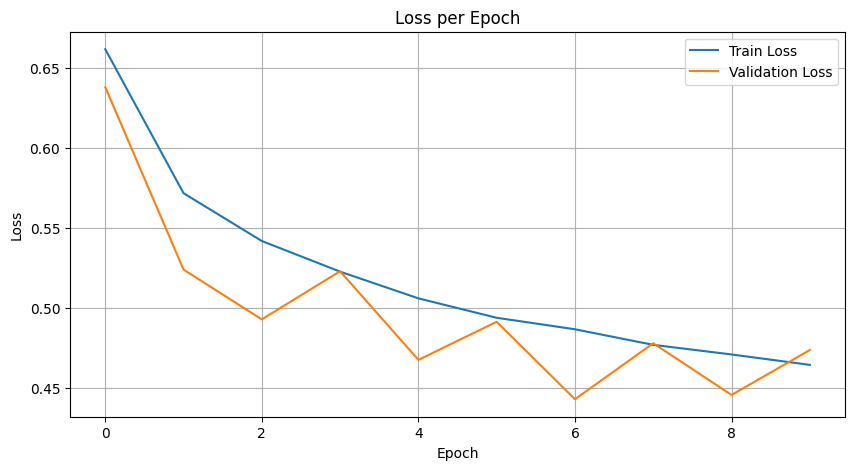

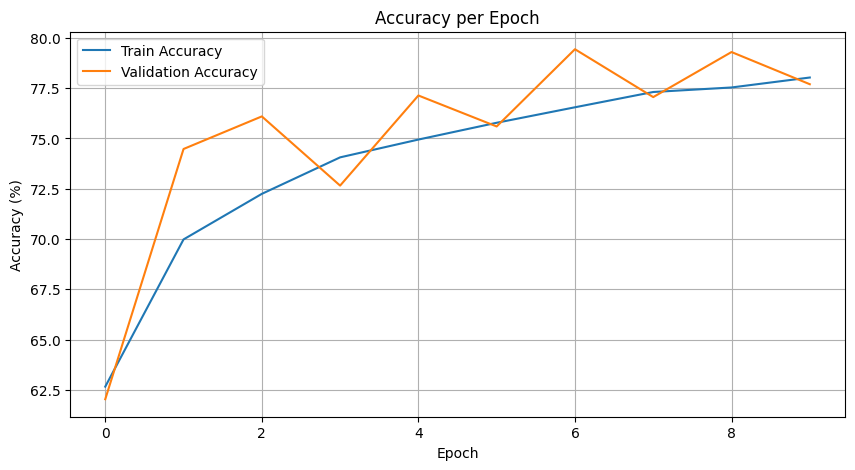

In [13]:
# Accuracy and losses graphs
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

I'm not sure why the validation accuracy and loss are fluctuating so much. Is it normal?